In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
%matplotlib widget

Util-функции

In [2]:
def draw_plots(rows, cols, width, height, subplot_data, legend_loc="best", legend_fontsize="small"):
    fig, axes = plt.subplots(rows, cols, figsize=(width, height))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    flat_data = [item for row in subplot_data for item in row]

    for idx, data in enumerate(flat_data):
        if idx >= len(axes):
            raise ValueError(f"Too many subplots provided in 'subplot_data': expected at most {rows * cols}, got more.")
        if not data:
            continue

        ax = axes[idx]

        (
            x_arrays, y_arrays,
            labels,
            x_label, y_label,
            colors, linestyles,
            linewidth, markers,
            markersizes, title,
            markerevery
        ) = data + [None] * (12 - len(data))

        num_plots = len(y_arrays)

        for i in range(num_plots):
            x = x_arrays[i]
            y = y_arrays[i]

            label = labels[i] if labels and i < len(labels) else None
            color = colors[i] if colors and i < len(colors) else None
            linestyle = linestyles[i] if linestyles and i < len(linestyles) else '-'
            lw = linewidth[i] if linewidth and i < len(linewidth) else 2
            marker = markers[i] if markers and i < len(markers) else None
            markersize = markersizes[i] if markersizes and i < len(markersizes) else None
            mevery = markerevery[i] if markerevery and i < len(markerevery) else None

            ax.plot(x, y,
                    label=label,
                    color=color,
                    linestyle=linestyle,
                    linewidth=lw,
                    marker=marker,
                    markersize=markersize,
                    markevery=mevery)

        if labels:
            ax.legend(loc=legend_loc, fontsize=legend_fontsize)
        ax.grid(True)
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)
        if title:
            ax.set_title(title)
    
    for idx in range(len(flat_data), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.gca().set_axisbelow(True) 
    plt.tight_layout()
    plt.show()

In [3]:
g = lambda t, a: a if (1 <= t <= 4) else 0
u = lambda t, a, b, c, d: g(t, a) + b * np.random.uniform(-1, 1) + c * np.sin(d * t)

# Задание 1.1

In [4]:
def calc_spectrum(signal, dt):
    spectrum = fftshift(np.abs(fft(signal)))
    freq = 2 * np.pi * fftshift(fftfreq(len(signal), dt))
    return freq, spectrum

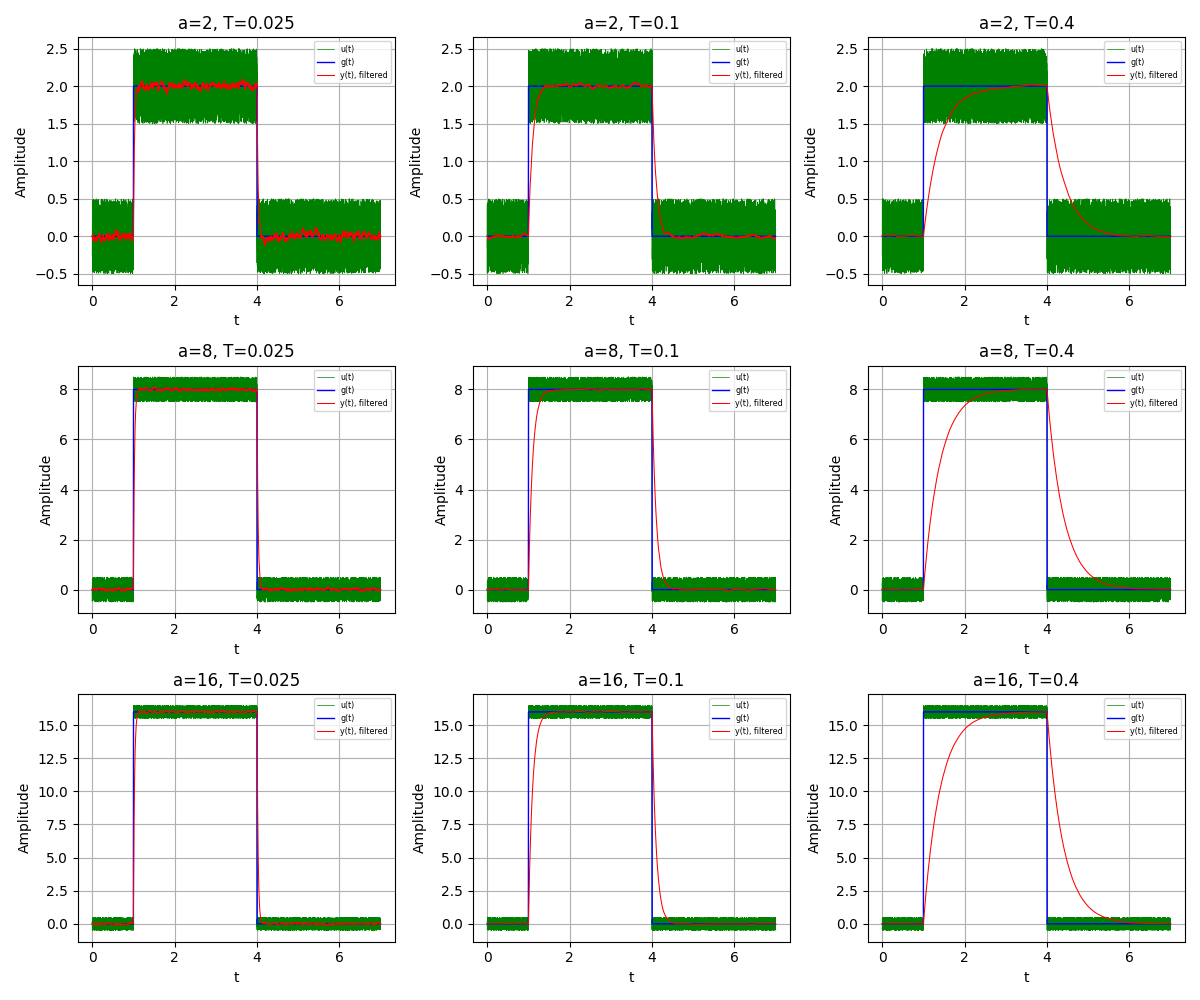

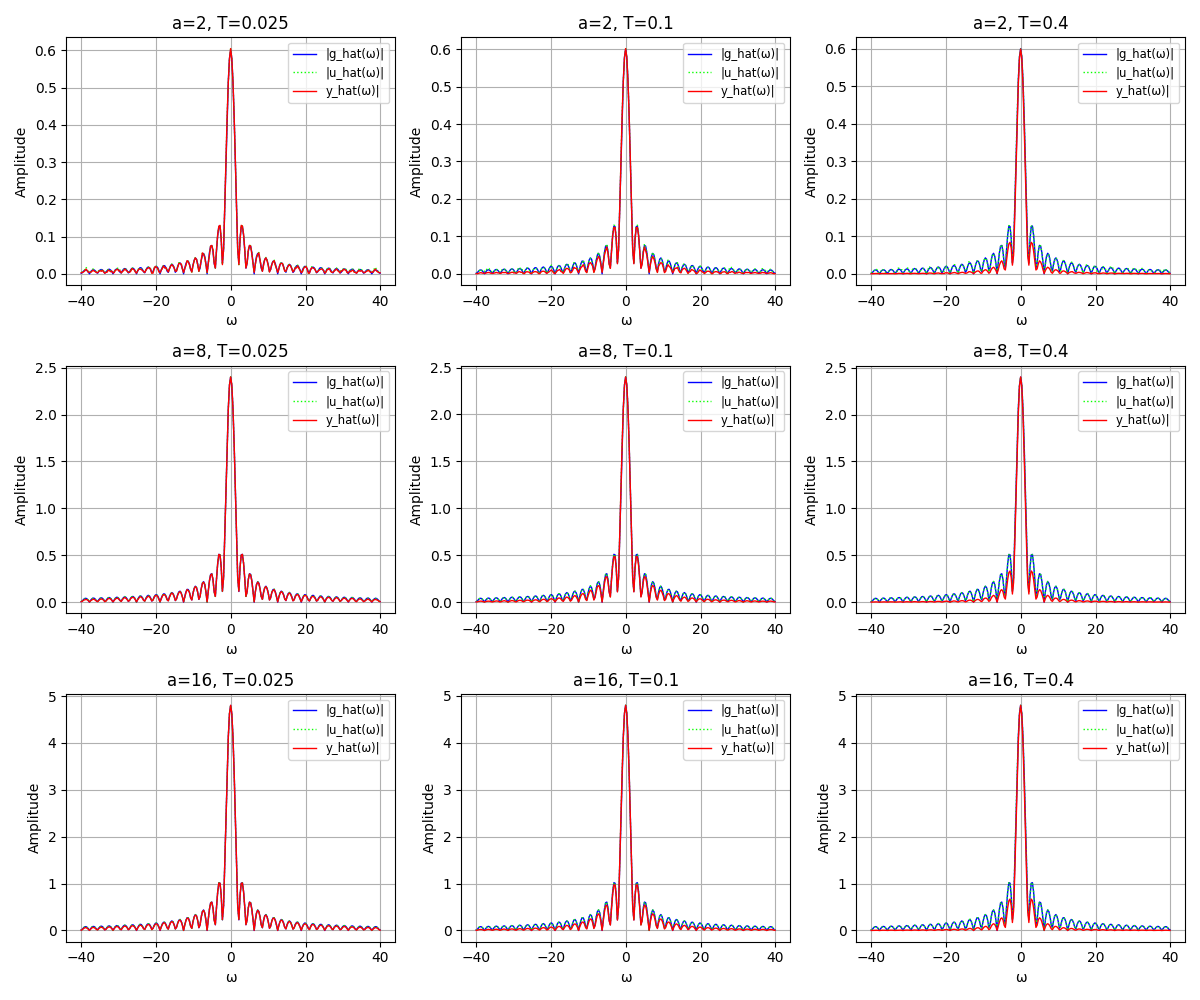

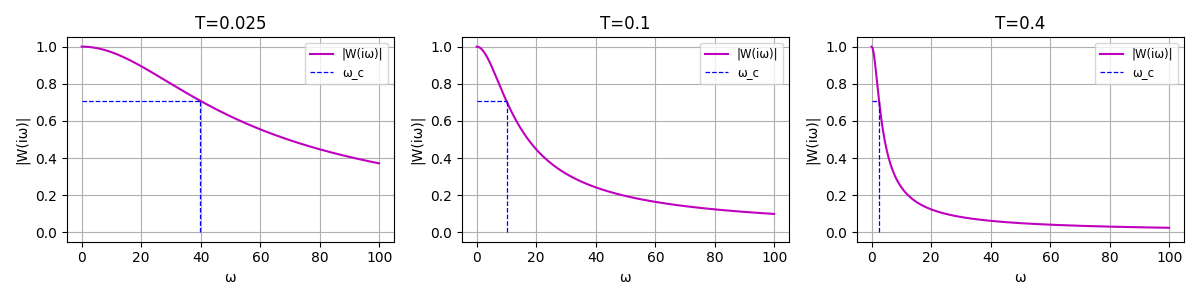

In [5]:
T_range = [0.025, 0.1, 0.4]
a_range = [2, 8, 16]
b = 0.5
c = 0
d = 10
plots_11 = []

t_start, t_end = 0, 20
num_points = 2 ** 15
t = np.linspace(t_start, t_end, num_points)
dt = t[1] - t[0]
N = len(t)

time_subplot_data = []
spectrum_subplot_data = []
freq_response_subplot_data = []

for i, a in enumerate(a_range):
    time_row = []
    spectrum_row = []
    freq_response_row = []
    
    for j, T in enumerate(T_range):
        g_signal = np.array([g(ti, a) for ti in t])
        u_signal = np.array([u(ti, a, b, c, d) for ti in t])
        
        sys = signal.TransferFunction([1], [T, 1])
        _, y_signal, _ = signal.lsim(sys, U=u_signal, T=t)
        
        freq_g, func_g = calc_spectrum(g_signal, dt)
        freq_u, func_u = calc_spectrum(u_signal, dt)
        freq_y, func_y = calc_spectrum(y_signal, dt)
        
        w = freq_g
        W_mag = 1 / np.sqrt(1 + (T * w)**2)
        
        afc_mask = (freq_g >= 0) & (freq_g < 100)
        omega_mask = np.abs(freq_g) < 40
        
        time_plot = [
            [t[t < 7]] * 3,
            [u_signal[t < 7], g_signal[t < 7], y_signal[t < 7]],
            ['u(t)', 'g(t)', 'y(t), filtered'],
            't', 'Amplitude',
            ['g', 'b', 'r'],
            ['-'] * 3,
            [0.5, 1.0, 0.75],
            [None] * 3,
            [None] * 3,
            f'a={a}, T={T}',
        ]
        time_row.append(time_plot)

        spectrum_plot = [
            [freq_g[omega_mask], freq_u[omega_mask], freq_y[omega_mask]],
            [2.0 / N * func_g[omega_mask],
             2.0 / N * func_u[omega_mask],
             2.0 / N * func_y[omega_mask]
            ],
            ['|g_hat(ω)|', '|u_hat(ω)|', 'y_hat(ω)|'],
            'ω', 'Amplitude',
            ['b', "#09FF00", 'r'],
            ['-', ':', '-'],
            [1.0, 1.0, 1.0],
            [None] * 3,
            [None] * 3,
            f'a={a}, T={T}',
        ]
        spectrum_row.append(spectrum_plot)
        
        target = 1/np.sqrt(2)
        idx = np.argmin(np.abs(W_mag[afc_mask] - target))
        cutoff_freq = freq_g[afc_mask][idx]
        cutoff_amp = W_mag[afc_mask][idx]

        freq_response_plot = [
            [freq_g[afc_mask], [cutoff_freq, cutoff_freq], [0, cutoff_freq]],
            [W_mag[afc_mask], [0, cutoff_amp], [cutoff_amp, cutoff_amp]],
            ['|W(iω)|', "ω_c", None],
            'ω', '|W(iω)|',
            ['m', 'b', 'b'],
            ['-', '--', '--'],
            [1.5, 0.9, 0.9],
            [None] * 3,
            [None] * 3,
            f'T={T}',
        ]
        freq_response_row.append(freq_response_plot)
    
    time_subplot_data.append(time_row)
    spectrum_subplot_data.append(spectrum_row)
    if i == 0:
        freq_response_subplot_data.append(freq_response_row)

draw_plots(
    rows=3,
    cols=3,
    width=12,
    height=10,
    subplot_data=time_subplot_data,
    legend_loc='upper right',
    legend_fontsize='xx-small'
)

draw_plots(
    rows=3,
    cols=3,
    width=12,
    height=10,
    subplot_data=spectrum_subplot_data,
    legend_loc='upper right'
)

draw_plots(
    rows=1,
    cols=3,
    width=12,
    height=3,
    subplot_data=freq_response_subplot_data,
    legend_loc='upper right'
)

In [ ]:
a1 = 0
a2 = 100
b2 = 100
a = 1
b = 0
c_range = [0, 0.5, 2]
d_range = [5, 10, 20]
b1_range = [5, 14.14, 20]

N = 2 ** 15
t = np.linspace(0, 20, N)
dt = t[1] - t[0]

time_subplot_data = []
spectrum_subplot_data = []
freq_response_subplot_data = []

for i, b1 in enumerate(b1_range):
    time_row = []
    spectrum_row = []
    freq_response_row = []
    
    for j, c in enumerate(c_range):
        for k, d in enumerate(d_range):
            g_signal = np.array([g(ti, a) for ti in t])
            u_signal = np.array([u(ti, a, b, c, d) for ti in t])
            
            sys = signal.TransferFunction([1, a1, a2], [1, b1, b2])
            _, y_signal, _ = signal.lsim(sys, U=u_signal, T=t)
            
            freq_g, func_g = calc_spectrum(g_signal, dt)
            freq_u, func_u = calc_spectrum(u_signal, dt)
            freq_y, func_y = calc_spectrum(y_signal, dt)
            
            w = freq_g
            W_mag = np.abs((1j*w)**2 + a1*(1j*w) + a2) / np.abs((1j*w)**2 + b1*(1j*w) + b2)#???
            
            afc_mask = (freq_g >= 0) & (freq_g < 30)
            omega_mask = np.abs(freq_g) < 30
            t_mask = t < 7

            time_plot = [
                [t[t_mask]] * 3,
                [u_signal[t_mask], g_signal[t_mask], y_signal[t_mask]],
                ['u(t)', 'g(t)', 'y(t), filtered'],
                't', 'Amplitude',
                ['g', 'b', 'r'],
                ['-'] * 3,
                [0.5, 1.0, 0.75],
                [None] * 3,
                [None] * 3,
                f'b1={b1:.2f}, c={c}, d={d}',
            ]
            time_row.append(time_plot)
            
            spectrum_plot = [
                [freq_g[omega_mask], freq_u[omega_mask], freq_y[omega_mask]],
                [2.0 / N * func_g[omega_mask],
                 2.0 / N * func_u[omega_mask],
                 2.0 / N * func_y[omega_mask]],
                ['|g_hat(ω)|', '|u_hat(ω)|', 'y_hat(ω)|'],
                'ω', 'Amplitude',
                ['b', "#09FF00", 'r'],
                ['-', ':', '-'],
                [1.0, 1.0, 1.0],
                [None] * 3,
                [None] * 3,
                f'b1={b1:.2f}, c={c}, d={d}',
            ]
            spectrum_row.append(spectrum_plot)
            
            if c == c_range[0] and d == d_range[0]:
                min_idx = np.argmin(W_mag[afc_mask])
                notch_freq = freq_g[afc_mask][min_idx]
                notch_amp = W_mag[afc_mask][min_idx]
                
                freq_response_plot = [
                    [freq_g[afc_mask], [notch_freq, notch_freq], [0, notch_freq]],
                    [W_mag[afc_mask], [0, notch_amp], [notch_amp, notch_amp]],
                    ['|W(iω)|', f"ω0={notch_freq:.1f}", None],
                    'ω', '|W(iω)|',
                    ['m', 'b', 'b'],
                    ['-', '--', '--'],
                    [1.5, 0.9, 0.9],
                    [None] * 3,
                    [None] * 3,
                    f'b1={b1:.2f} (ζ={b1/(2*np.sqrt(b2)):.2f})',
                ]
                freq_response_row.append(freq_response_plot)
    
    time_subplot_data.append([time_row])
    spectrum_subplot_data.append([spectrum_row])
    freq_response_subplot_data.append(freq_response_row)

for tsd in time_subplot_data:
    draw_plots(
        rows=3,
        cols=3,
        width=12,
        height=10,
        subplot_data=tsd,
        legend_loc='upper right',
        legend_fontsize='xx-small'
    )

for ssd in spectrum_subplot_data:
    draw_plots(
        rows=3,
        cols=3,
        width=10,
        height=12,
        subplot_data=ssd,
        legend_loc='upper right'
    )

draw_plots(
    rows=1,
    cols=3,
    width=12,
    height=3,
    subplot_data=freq_response_subplot_data,
    legend_loc='upper right'
)